In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import cv2

In [2]:
# Linear filtering is the basic of using a kernel for convolution

# Due to convolution reduction in the resulting image, the following types of padding can be added to the original image
# zero: set all pixels outside the source image to 0 (a good choice for alpha-matted cutout images);
# constant: set all pixels outside the source image to a specified border value;
# clamp: repeat the edge pixels indefinitely;
# wrap: loop "around" the image in a toroidal configuration;
# mirror: reflect pixels across the image edge;
# extend: extend the signal by subtracting the mirrored version of the signal from the edge pixel value;

def constant_padding(image: np.ndarray, kernel_size: int, constant: int) -> np.ndarray:
    assert kernel_size % 2 == 1, "Kernel size has to be an odd number"
    assert constant >= 0 and constant <= 255, "invalid pixel intensity value for padding"
    pad = kernel_size // 2

    new_image = np.full((image.shape[0] + 2*pad, image.shape[1] + 2*pad, image.shape[2]), constant, dtype="uint8")
    new_image[pad:-pad,pad:-pad,:] = image

    return new_image.astype("uint8")


def zero_padding(image: np.ndarray, kernel_size: int) -> np.ndarray:
    
    return constant_padding(image, kernel_size, 0)


def clamp_padding(image: np.ndarray, kernel_size: int) -> np.ndarray:
    pad = kernel_size // 2
    new_image = zero_padding(image, kernel_size)
    # left
    new_image[pad:-pad,:pad,:] = np.stack([image[:,0,:].reshape(image.shape[0], image.shape[2])] * pad, axis=1)
    # right
    new_image[pad:-pad,-pad:,:] = np.stack([image[:,-1,:].reshape(image.shape[0], image.shape[2])] * pad, axis=1)
    # top
    new_image[:pad,:,:] = np.stack([new_image[pad,:,:].reshape(new_image.shape[1], new_image.shape[2])] * pad, axis=0)
    # bottom
    new_image[-pad:,:,:] = np.stack([new_image[-pad-1,:,:].reshape(new_image.shape[1], new_image.shape[2])] * pad, axis=0)

    return new_image


def wrap_padding(image: np.ndarray, kernel_size: int) -> np.ndarray:
    assert kernel_size % 2 == 1, "Kernel size has to be an odd number"
    assert kernel_size < min(image.shape[0], image.shape[1]), "padding should not exceed the original size of the image"
    pad = kernel_size // 2
    # now wrap with repeat configuration of the original image to form a 9-tile collage, 
    # where the original image should be in the center of the resulting tiles
    new_image = image
    height, width, _ = new_image.shape
    new_image = np.hstack([new_image] * 3)
    new_image = np.vstack([new_image] * 3)

    return new_image[height-pad:pad-height, width-pad:pad-width, :]


def mirror_padding(image: np.ndarray, kernel_size: int) -> np.ndarray:
    assert kernel_size < min(image.shape[0], image.shape[1]), "padding should not exceed the original size of the image"
    pad = kernel_size // 2
    # similar to the wrap padding, the mirror padding mirror the original image at the border
    new_image = wrap_padding(image, kernel_size)
    # swap left, right
    left, right = new_image[pad:-pad, :pad, :].copy(), new_image[pad:-pad, -pad:, :].copy()
    new_image[pad:-pad, :pad, :], new_image[pad:-pad, -pad:, :] = right[:,::-1,:], left[:,::-1,:]

    # swap top, bottom
    top, bottom = new_image[:pad, pad:-pad, :].copy(), new_image[-pad:, pad:-pad, :].copy()
    new_image[:pad, pad:-pad, :], new_image[-pad:, pad:-pad, :] = bottom[::-1,:,:], top[::-1,:,:]

    # swap corners
    c1, c2 = new_image[:pad, :pad, :].copy(), new_image[-pad:, -pad:, :].copy()
    new_image[:pad, :pad, :], new_image[-pad:, -pad:, :] = c2[::-1, ::-1, :], c1[::-1, ::-1, :]

    c1, c2 = new_image[:pad, -pad:, :].copy(), new_image[-pad:, :pad, :].copy()
    new_image[:pad, -pad:, :], new_image[-pad:, :pad, :] = c2[::-1, ::-1, :], c1[::-1, ::-1, :]

    return new_image


def extend_padding(image: np.ndarray, kernel_size: int) -> np.ndarray:
    assert kernel_size < min(image.shape[0], image.shape[1]), "padding should not exceed the original size of the image"

    mask = np.zeros(image.shape)
    mask = constant_padding(mask, kernel_size, 1)
    mask = np.ma.make_mask(mask == 0)
    clamp = np.ma.array(clamp_padding(image, kernel_size), mask=mask).astype("uint8")
    mirror = np.ma.array(mirror_padding(image, kernel_size), mask=mask).astype("uint8")

    return np.array(mirror - clamp).clip(min=0).astype("uint8")

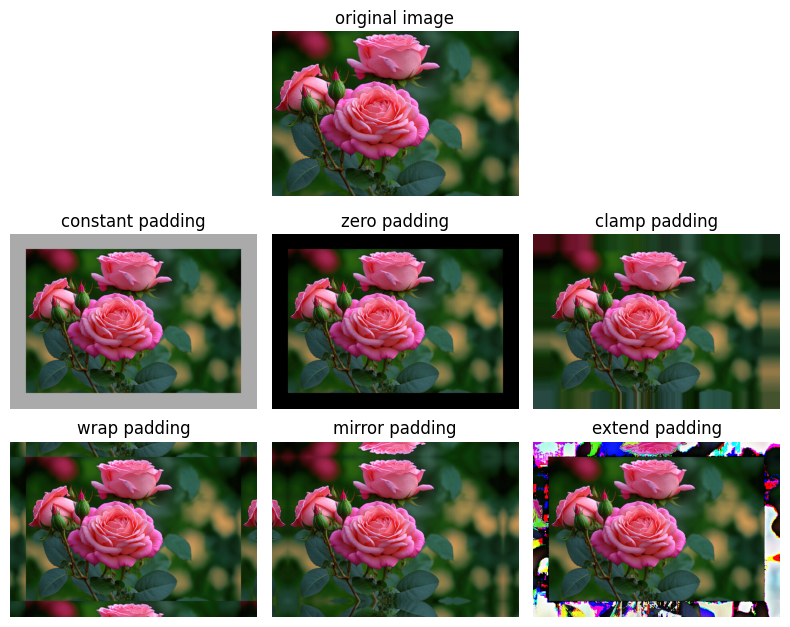

In [3]:
img = mpimg.imread("sample/flower.jpg")
kernel_size = 81

fig, axis = plt.subplots(3, 3, figsize=(8, 8))
[axis[i,j].axis("off") for i in range(3) for j in range(3)]
axis[0,0].imshow(np.full(img.shape, 255).astype("uint8"))
axis[0,1].imshow(img)
axis[0,1].set_title("original image")
axis[0,2].imshow(np.full(img.shape, 255).astype("uint8"))
axis[1,0].imshow(constant_padding(img, kernel_size, 170))
axis[1,0].set_title("constant padding")
axis[1,1].imshow(zero_padding(img, kernel_size))
axis[1,1].set_title("zero padding")
axis[1,2].imshow(clamp_padding(img, kernel_size))
axis[1,2].set_title("clamp padding")
axis[2,0].imshow(wrap_padding(img, kernel_size))
axis[2,0].set_title("wrap padding")
axis[2,1].imshow(mirror_padding(img, kernel_size))
axis[2,1].set_title("mirror padding")
axis[2,2].imshow(extend_padding(img, kernel_size))
axis[2,2].set_title("extend padding")

plt.subplots_adjust(wspace=0.03, hspace=0.03)
fig.tight_layout(h_pad=-8.0)
plt.show()

In [4]:
# 3.2.1 Separable Filtering
# A convolutional filter of (K, K) is said to be separable if the filtering process can be done
# with horizontal 1-d filter (K, ) and vertical 1-d filter of (K, )

# compute the SVD of the kernel, it will be separable if only the first singular value is non-zero
# if the matrix is rank 1, it will be separable
def separable_filters(kernel: np.ndarray) -> bool | tuple[np.ndarray, np.ndarray]:
    rank = np.linalg.matrix_rank(kernel)
    if rank != 1:
        # only matrix rank 1 will be separable
        return False
    
    u, s, v = np.linalg.svd(kernel)
    if not (np.allclose(s[1:], np.zeros((len(s)-1,))) and s[0] != 0):
        # only the first singular value is non-zero
        return False

    # computer the horizontal and vertical equavalent kernels
    # note that it is alright to have the 1D filters with negative values as both multiplication will cancel out
    return v[0] * np.sqrt(s[0]), u[:,:1] * np.sqrt(s[0])



def convolution_2d(source: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    source = source.copy()
    kernel_shape = kernel.shape

    if len(kernel.shape) == 1:
        # 1-d horizontal kernel add one dimension
        kernel = kernel[None, :]

    assert len(source.shape) == 3, "Source image should have at least 1 channel"
    _, _, channel = source.shape

    def conv2d_one_channel(layer: np.ndarray) -> np.ndarray:
        sub = tuple(np.subtract(layer.shape, kernel.shape) + 1) + kernel.shape
        as_strided = np.lib.stride_tricks.as_strided
        sub_matrices = as_strided(layer, sub, layer.strides * 2)

        return np.einsum('ij,klij->kl', kernel, sub_matrices)
    
    return np.stack([conv2d_one_channel(source[:,:,c]) for c in range(channel)], axis=-1)


def linear_filtering(image: np.ndarray, kernel: np.ndarray, padding: str = "zero", sep: bool = True) -> np.ndarray:
    match padding:
        case "zero":
            new_image = zero_padding(image, kernel_size=kernel.shape[0])
        case "clamp":
            new_image = clamp_padding(image, kernel_size=kernel.shape[0])
        case "wrap":
            new_image = wrap_padding(image, kernel_size=kernel.shape[0])
        case "mirror":
            new_image = mirror_padding(image, kernel_size=kernel.shape[0])
        case "extend":
            new_image = extend_padding(image, kernel_size=kernel.shape[0])
        case _:
            raise ValueError("Invalid padding mode")
        
    separable = separable_filters(kernel)
    if separable == False or not sep:
        # normal 2D convolution on new_image
        new_image = convolution_2d(new_image, kernel)
    else:
        # compute the horizontal and vertical kernels
        assert isinstance(separable, tuple), "Invalid parameters"
        h, v = separable
        new_image = convolution_2d(new_image, h)
        new_image = convolution_2d(new_image, v)

    return np.round(new_image).astype("uint8")

Normal non-separable fitler duration: 1426 ms
Separable fitler but traditional 2D convolution duration: 1436 ms
Separable fitler improved 2D convolution duration: 57 ms


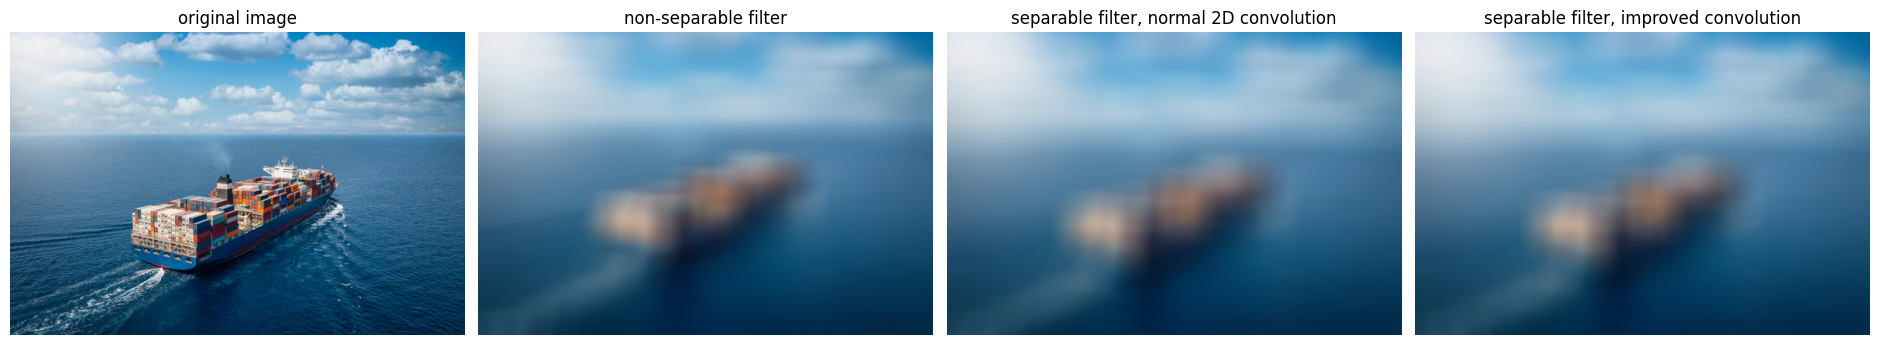

In [5]:
import time

img = mpimg.imread("sample/ship.jpg")

kernel1 = np.arange(2601).reshape(51, 51).astype("float")
kernel1 /= np.sum(kernel1)

kernel2 = np.ones((51, 51)).astype("float")
kernel2 /= np.sum(kernel2)

# non-separable filter
start = int(time.time()*1000)
filter1 = linear_filtering(img, kernel1, padding="clamp")
duration1 = int(time.time()*1000) - start
start = int(time.time()*1000)
print("Normal non-separable fitler duration:", f"{duration1} ms")

# traditional convolution
filter2 = linear_filtering(img, kernel2, padding="clamp", sep = False)
duration2 = int(time.time()*1000) - start
start = int(time.time()*1000)
print("Separable fitler but traditional 2D convolution duration:", f"{duration2} ms")

# separable filter convolution
filter3 = linear_filtering(img, kernel2, padding="clamp")
duration3 = int(time.time()*1000) - start
print("Separable fitler improved 2D convolution duration:", f"{duration3} ms")

fig, axis = plt.subplots(1, 4, figsize=(6, 6))
axis[0].set_title("original image")
axis[0].axis("off")
axis[0].imshow(img)
axis[1].set_title("non-separable filter")
axis[1].axis("off")
axis[1].imshow(filter1)
axis[2].set_title("separable filter, normal 2D convolution")
axis[2].axis("off")
axis[2].imshow(filter2)
axis[3].set_title("separable filter, improved convolution")
axis[3].axis("off")
axis[3].imshow(filter3)

plt.subplots_adjust(wspace=0.03, hspace=0.03)
fig.set_figwidth(24)
plt.show()

OpenCV 2D filtering duration: 7ms


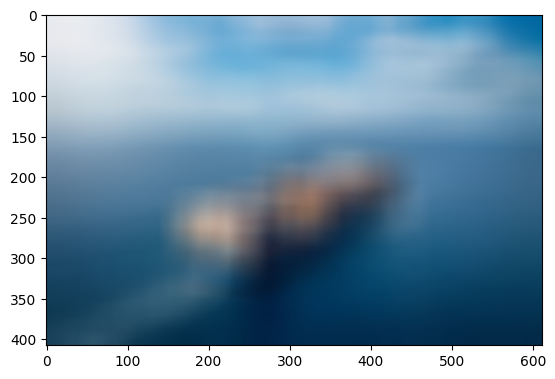

In [6]:
# OpenCV implementation of 2D filtering is already optimized
start = int(time.time()*1000)
opencv_filter = cv2.filter2D(img, ddepth=-1, kernel=kernel2)
duration = int(time.time()*1000) - start

print("OpenCV 2D filtering duration:", f"{duration}ms")
plt.imshow(opencv_filter)
plt.show()

In [7]:
# 3.2.3 Band-pass and Steerable Filters

# Gaussian filter
def gaussian_filter(kernel_size: int, std: float = 1.) -> np.ndarray:
    assert kernel_size % 2 == 1, "Gaussian filter kernel size should be an odd number"
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.float64)
    
    for i in range(kernel_size):
        for j in range(kernel_size):
            x, y = i - (kernel_size + 1) / 2.0, j - (kernel_size + 1) / 2.0
            kernel[i, j] = np.exp(-(x**2+y**2)/(2*std**2))/(2 * np.pi * std**2)

    # return the filter with summation equals to 1.
    return kernel / np.sum(kernel)

def laplacian_gaussian_filter(kernel_size: int, std: float = 1.) -> np.ndarray:
    kernel = gaussian_filter(kernel_size, std)

    for i in range(kernel_size):
        for j in range(kernel_size):
            x, y = i - (kernel_size + 1) / 2.0, j - (kernel_size + 1) / 2.0
            kernel[i, j] *= ((x**2 + y**2)/std**4 - 2/std**2)

    # return the filter with summation equals to 1.
    return kernel / np.sum(kernel)


def sobel_filter(kernel_size: int, std: float = 1.) -> np.ndarray:
    kernel = gaussian_filter(kernel_size, std)

    #TODO

    # return the filter with summation equals to 1.
    return kernel / np.sum(kernel)


print("Gaussian filter size 3 standard deviation 1.0")
print(gaussian_filter(3))

print("Laplacian of Gaussian filter size 3 standard deviation 1.0")
print(laplacian_gaussian_filter(3))

print("Sobel filter size 3 standard deviation 1.0")
print(sobel_filter(3))


Gaussian filter size 3 standard deviation 1.0
[[0.0060366  0.02705418 0.0446048 ]
 [0.02705418 0.12124841 0.19990484]
 [0.0446048  0.19990484 0.32958736]]
Laplacian of Gaussian filter size 3 standard deviation 1.0
[[-0.05310635 -0.11900307 -0.13080193]
 [-0.11900307 -0.          0.29310678]
 [-0.13080193  0.29310678  0.96650277]]
Sobel filter size 3 standard deviation 1.0
[[0.0060366  0.02705418 0.0446048 ]
 [0.02705418 0.12124841 0.19990484]
 [0.0446048  0.19990484 0.32958736]]


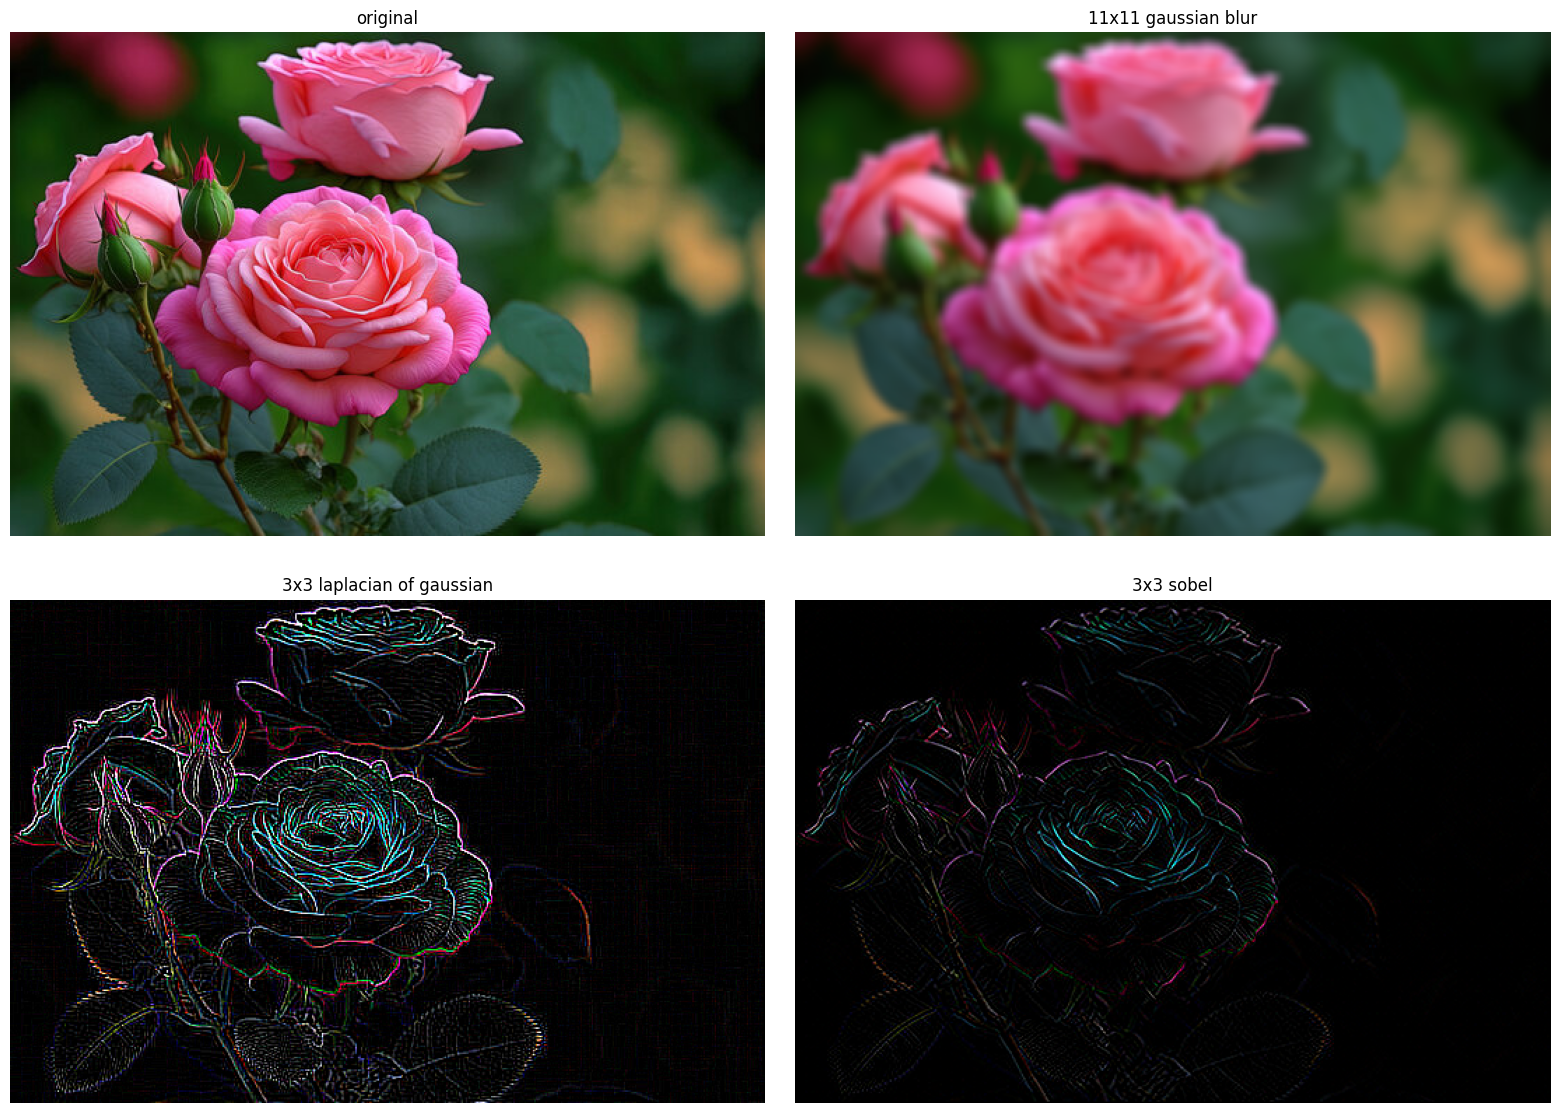

In [8]:
# OpenCV Gaussian Blur implementation
img = mpimg.imread("sample/flower.jpg")
blurred_img = cv2.GaussianBlur(img, (11, 11), cv2.BORDER_DEFAULT)
laplacian_img = cv2.Laplacian(img, ddepth=-1, ksize=3, borderType=cv2.BORDER_DEFAULT)
sobel_img = cv2.Sobel(img, ddepth=-1, dx=1, dy=1, ksize=3, borderType=cv2.BORDER_DEFAULT)

fig, axis = plt.subplots(2, 2, figsize=(8, 8))

axis[0, 0].imshow(img)
axis[0, 0].set_title("original")
axis[0, 0].axis("off")
axis[0, 1].imshow(blurred_img)
axis[0, 1].set_title("11x11 gaussian blur")
axis[0, 1].axis("off")
axis[1, 0].imshow(laplacian_img)
axis[1, 0].set_title("3x3 laplacian of gaussian")
axis[1, 0].axis("off")
axis[1, 1].imshow(sobel_img)
axis[1, 1].set_title("3x3 sobel")
axis[1, 1].axis("off")

plt.subplots_adjust(wspace=0.03, hspace=0.03)
fig.tight_layout(h_pad=-9.0)
fig.set_figwidth(16)
fig.set_figheight(16)
plt.show()

In [9]:
# Area Sum Table: algorithmn for improving the repeated sum query

# building the area sum table using dynamic programming starting from (0, 0)
# this area sum table can be applied for higher dimensions
def area_sum_table(source: np.ndarray) -> np.ndarray:
    source = source.copy()
    assert len(source.shape) == 2, "Demostration using 2-d array as an example"
    m, n = source.shape

    for i in range(m):
        for j in range(n):
            source[i, j] += source[i-1, j] if i > 0 else 0
            source[i, j] += source[i, j-1] if j > 0 else 0
            source[i, j] -= source[i-1, j-1] if i > 0 and j > 0 else 0

    return source


def query_sum(table: np.ndarray, top_left: tuple[int, int], bottom_right: tuple[int, int]) -> int:
    x1, y1 = top_left
    x2, y2 = bottom_right

    result = table[x2, y2]
    result += table[x1-1, y1-1] if x1 > 0 and y1 > 0 else 0
    result -= table[x1-1, y2] if x1 > 0 else 0
    result -= table[x2, y1-1] if y1 > 0 else 0

    return result


# suppose we have an image of size 20 x 20
img = np.arange(400, dtype=np.uint64).reshape(20, 20)
sum_table = area_sum_table(img)

query_top_left = (3, 3)
query_bottom_right = (15, 15)

sum_by_table = query_sum(sum_table, query_top_left, query_bottom_right)
sum_by_array = np.sum(img[query_top_left[0]:query_bottom_right[0]+1,query_top_left[1]:query_bottom_right[1]+1])

print("Sum using area sum table:", sum_by_table)
print("Sum using array sum:", sum_by_array)

Sum using area sum table: 31941
Sum using array sum: 31941
